## Data exploration SMARD energy data for Germany overall together with the 4 energy providers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta
import matplotlib
import os

root_dir = "../../data/raw/smard/"
filenames = [filenames for dipath, dirname, filenames in os.walk(root_dir)][0]
filenames.sort()
filenames.remove(".DS_Store")
filenames_load = [filename for filename in filenames if "consumption" in filename]
filenames_gen = [filename for filename in filenames if "generation" in filename]
assert len(filenames_load) == len(filenames_gen)
assert len(filenames) == (len(filenames_load) + len(filenames_gen))
assert len(filenames) == 18
print(filenames)
#print(filenames_load)
#print(filenames_gen)

dfs_load = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_load]
load_column_names = [filename.split("smard_consumption_")[1].split(".csv")[0] for filename in filenames_load]
#print(load_column_names)
dfs_gen = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_gen]
gen_column_names = [filename.split("smard_generation_")[1].split(".csv")[0] for filename in filenames_gen]
#print(gen_column_names)


['smard_consumption_AT.csv', 'smard_consumption_AT_APG.csv', 'smard_consumption_DE.csv', 'smard_consumption_DE_50Hertz.csv', 'smard_consumption_DE_Amprion.csv', 'smard_consumption_DE_TenneT.csv', 'smard_consumption_DE_TransnetBW.csv', 'smard_consumption_LU.csv', 'smard_consumption_LU_Creos.csv', 'smard_generation_AT.csv', 'smard_generation_AT_APG.csv', 'smard_generation_DE.csv', 'smard_generation_DE_50Hertz.csv', 'smard_generation_DE_Amprion.csv', 'smard_generation_DE_TenneT.csv', 'smard_generation_DE_TransnetBW.csv', 'smard_generation_LU.csv', 'smard_generation_LU_Creos.csv']


/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_97326/2582214825.py:25: DtypeWarning: Columns (6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_gen = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_gen]
/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_97326/2582214825.py:25: DtypeWarning: Columns (6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_gen = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_gen]
/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_97326/2582214825.py:25: DtypeWarning: Columns (4,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_gen = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_gen]
/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_97326/2582214825.py:25: DtypeWarning: Columns (3,7,10) have mixed types. Specify dtype option on import or set low_memory

## Consumption

In [2]:
print(dfs_load[0]["Total (grid load) [MWh] Calculated resolutions"].head())
dfs_load_pp = []
for i, (col_name, df) in enumerate(zip(load_column_names, dfs_load)):
    #print(i)
    df["date"] = pd.to_datetime(df['Date'] + ' ' + df['Start'], format='%b %d, %Y %I:%M %p')
    df = df.drop(columns=["Date", "Start", "End"])
    df = df.rename(columns={"Total (grid load) [MWh] Calculated resolutions": "load"})
    df = df[["date"] + ["load"]]
    df["load"] = df["load"].astype(str).str.replace(',', '')
    if df["load"].str.contains("-").any():
        print("Dealing with nans in dataset", i)
        df["load"] = df["load"].replace('-', np.nan).astype(float)
        nan_rows = df["load"][df["load"].isna()]
        for j in list(nan_rows.index):
            #print(df.loc[j, "load"])
            #print("replaced")
            df.loc[j, "load"] = (df.loc[j-24, "load"] + df.loc[j+24, "load"]) / 2
            #rint(df.loc[j, "load"])

    df[f"load_{col_name}"] = df["load"].astype(float)
    df = df.drop(columns=["load"])
    if i != 0:
        df = df.drop(columns=["date"])

    dfs_load_pp.append(df)

print(dfs_load_pp[0].head())
load = pd.concat(dfs_load_pp, axis=1)
load

0     6,068.5
1     5,963.5
2    5,726.25
3       5,347
4       5,249
Name: Total (grid load) [MWh] Calculated resolutions, dtype: object
Dealing with nans in dataset 7
Dealing with nans in dataset 8
                 date  load_AT
0 2015-01-01 00:00:00  6068.50
1 2015-01-01 01:00:00  5963.50
2 2015-01-01 02:00:00  5726.25
3 2015-01-01 03:00:00  5347.00
4 2015-01-01 04:00:00  5249.00


,date,load_AT,load_AT_APG,load_DE,load_DE_50Hertz,load_DE_Amprion,load_DE_TenneT,load_DE_TransnetBW,load_LU,load_LU_Creos
0,2015-01-01 00:00:00,6068.50,6068.50,44600.25,9211.50,15245.75,14110.25,5470.00,423.25,423.25
1,2015-01-01 01:00:00,5963.50,5963.50,43454.75,8981.25,15201.50,13267.50,5327.00,403.75,403.75
2,2015-01-01 02:00:00,5726.25,5726.25,41963.25,8782.75,14826.00,12642.00,5087.25,383.25,383.25
3,2015-01-01 03:00:00,5347.00,5347.00,40617.75,8605.50,14405.00,12132.50,4905.50,370.00,370.00
4,2015-01-01 04:00:00,5249.00,5249.00,39936.75,8536.00,14083.25,11840.25,4865.00,363.75,363.75
...,...,...,...,...,...,...,...,...,...,...
78883,2023-12-31 19:00:00,6765.50,6765.50,50254.75,11481.75,17755.75,15318.25,5699.50,500.50,500.50
78884,2023-12-31 20:00:00,6398.75,6398.75,47086.50,10769.50,16645.25,14291.00,5380.75,478.75,478.75
78885,2023-12-31 21:00:00,6057.50,6057.50,45238.50,10260.75,15929.75,13768.00,5280.75,456.25,456.25
78886,2023-12-31 22:00:00,6091.00,6091.00,44099.25,9930.00,15420.00,13459.75,5289.50,454.00,454.00


In [3]:
load.describe() 




,date,load_AT,load_AT_APG,load_DE,load_DE_50Hertz,load_DE_Amprion,load_DE_TenneT,load_DE_TransnetBW,load_LU,load_LU_Creos
count,78888,78888.00000,78888.00000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000
mean,2019-07-02 12:05:15.972011008,7040.87557,7040.87557,56360.112254,11816.464659,20559.505853,16989.426598,6975.234424,528.421810,528.421810
min,2015-01-01 00:00:00,663.25000,663.25000,30909.000000,6287.500000,9590.500000,9088.000000,3249.750000,0.000000,0.000000
25%,2017-04-01 18:45:00,5945.00000,5945.00000,48133.375000,10275.500000,17662.250000,14409.187500,5710.500000,453.000000,453.000000
50%,2019-07-02 12:30:00,6993.25000,6993.25000,56045.625000,11871.750000,20447.750000,16837.500000,6878.000000,524.750000,524.750000
75%,2021-10-01 06:15:00,8037.00000,8037.00000,64691.625000,13280.000000,23548.250000,19565.312500,8253.500000,603.000000,603.000000
max,2023-12-31 23:00:00,10802.75000,10802.75000,81077.500000,18106.000000,32060.000000,24853.500000,10845.000000,843.250000,843.250000
std,NaN,1366.17161,1366.17161,10000.237611,1944.401277,3617.131395,3146.330621,1503.801276,110.575783,110.575783


In [4]:
load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                78888 non-null  datetime64[ns]
 1   load_AT             78888 non-null  float64       
 2   load_AT_APG         78888 non-null  float64       
 3   load_DE             78888 non-null  float64       
 4   load_DE_50Hertz     78888 non-null  float64       
 5   load_DE_Amprion     78888 non-null  float64       
 6   load_DE_TenneT      78888 non-null  float64       
 7   load_DE_TransnetBW  78888 non-null  float64       
 8   load_LU             78888 non-null  float64       
 9   load_LU_Creos       78888 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 6.0 MB


## Generation

In [5]:
#print(dfs_gen[0]["Wind onshore [MWh] Calculated resolutions"].head())
dfs_gen_pp = []
for i, (col_name, df) in enumerate(zip(gen_column_names, dfs_gen)):
    
    # Create date, wind_gen_onshore, solar_gen columns of type string
    df["date"] = pd.to_datetime(df['Date'] + ' ' + df['Start'], format='%b %d, %Y %I:%M %p')
    df = df.drop(columns=["Date", "Start", "End"])
    df = df.rename(columns={"Wind onshore [MWh] Calculated resolutions": "wind_gen_onshore", "Wind offshore [MWh] Calculated resolutions": "wind_gen_offshore", "Photovoltaics [MWh] Calculated resolutions": "solar_gen"})
    df["wind_gen_onshore"] = df["wind_gen_onshore"].astype(str)
    df["solar_gen"] = df["solar_gen"].astype(str)

    # Calculate total wind_gen
    if df.columns.str.contains("wind_gen_offshore").any():
        df["wind_gen_offshore"] = df["wind_gen_offshore"].astype(str)
        df["wind_gen"] = df["wind_gen_offshore"].str.replace(',', '').replace('-', np.nan).astype(float) + df["wind_gen_onshore"].str.replace(',', '').replace('-', np.nan).astype(float)
        df = df.drop(columns=["wind_gen_offshore", "wind_gen_onshore"])
    else:
        df["wind_gen"] = df["wind_gen_onshore"].str.replace(',', '').replace('-', np.nan).astype(float)
        df = df.drop(columns=["wind_gen_onshore"])

    # Calculate total solar_gen
    df["solar_gen"] = df["solar_gen"].str.replace(',', '').replace('-', np.nan).astype(float)

    # Concatenate df
    df = df[["date"] + ["solar_gen", "wind_gen"]]

    print("----------------------------------")
    # Dealing with nans in solar_gen
    if df["solar_gen"].isna().any():
        print("Dealing with solar nans in dataset", i, col_name)
        nan_rows = df["solar_gen"][df["solar_gen"].isna()]
        for j in list(nan_rows.index):
            
            df.loc[j, "solar_gen"] = (df.loc[j-24, "solar_gen"] + df.loc[j+24, "solar_gen"]) / 2
            print("\tNan at location ", j, "is replaced with", df.loc[j, "solar_gen"])

    # Dealing with nans in wind_gen
    if df["wind_gen"].isna().any():
        print("Dealing with wind nans in dataset", i)
        print("\tCounter", df["wind_gen"].isna().sum())
    
        df["wind_gen"] = df["wind_gen"].interpolate()

    # Rename columns
    df[f"solar_gen_{col_name}"] = df["solar_gen"].astype(float)
    df[f"wind_gen_{col_name}"] = df["wind_gen"].astype(float)
    df = df.drop(columns=["solar_gen", "wind_gen"])

    # Drop date column such that only one date column remains
    if i != 0:
        df = df.drop(columns=["date"])

    dfs_gen_pp.append(df)

gen = pd.concat(dfs_gen_pp, axis=1)
gen.head(15)

----------------------------------
Dealing with solar nans in dataset 0 AT
	Nan at location  66142 is replaced with 0.0
Dealing with wind nans in dataset 0
	Counter 1
----------------------------------
Dealing with solar nans in dataset 1 AT_APG
	Nan at location  66142 is replaced with 0.0
Dealing with wind nans in dataset 1
	Counter 1
----------------------------------
----------------------------------
----------------------------------
----------------------------------
----------------------------------
Dealing with solar nans in dataset 6 DE_TransnetBW
	Nan at location  66045 is replaced with 0.0
	Nan at location  66046 is replaced with 0.0
Dealing with wind nans in dataset 6
	Counter 4
----------------------------------
----------------------------------


,date,solar_gen_AT,wind_gen_AT,solar_gen_AT_APG,wind_gen_AT_APG,solar_gen_DE,wind_gen_DE,solar_gen_DE_50Hertz,wind_gen_DE_50Hertz,solar_gen_DE_Amprion,wind_gen_DE_Amprion,solar_gen_DE_TenneT,wind_gen_DE_TenneT,solar_gen_DE_TransnetBW,wind_gen_DE_TransnetBW,solar_gen_LU,wind_gen_LU,solar_gen_LU_Creos,wind_gen_LU_Creos
0,2015-01-01 00:00:00,0.00,65.00,0.00,65.00,0.00,8644.50,0.00,3688.50,0.00,891.50,0.00,4060.00,0.00,4.25,0.0,0.00,0.0,0.00
1,2015-01-01 01:00:00,0.00,70.00,0.00,70.00,0.00,8813.75,0.00,4063.50,0.00,862.25,0.00,3883.50,0.00,5.00,0.0,0.00,0.0,0.00
2,2015-01-01 02:00:00,0.00,64.00,0.00,64.00,0.00,9054.00,0.00,4279.50,0.00,793.75,0.00,3973.50,0.00,7.00,0.0,0.00,0.0,0.00
3,2015-01-01 03:00:00,0.00,65.00,0.00,65.00,0.00,9069.75,0.00,4042.00,0.00,825.75,0.00,4194.00,0.00,7.75,0.0,0.00,0.0,0.00
4,2015-01-01 04:00:00,0.00,64.00,0.00,64.00,0.00,9163.25,0.00,3854.75,0.00,851.50,0.00,4446.00,0.00,10.75,0.0,0.00,0.0,0.00
5,2015-01-01 05:00:00,0.00,63.50,0.00,63.50,0.00,9231.75,0.00,3753.25,0.00,800.50,0.00,4672.00,0.00,6.25,0.0,0.00,0.0,0.00
6,2015-01-01 06:00:00,0.00,83.75,0.00,83.75,0.00,9688.75,0.00,3774.25,0.00,949.25,0.00,4963.25,0.00,2.00,0.0,0.00,0.0,0.00
7,2015-01-01 07:00:00,0.00,131.00,0.00,131.00,0.00,10331.25,0.00,4053.75,0.00,1298.00,0.00,4973.75,0.00,6.00,0.0,0.00,0.0,0.00
8,2015-01-01 08:00:00,1.75,109.50,1.75,109.50,53.00,10208.25,27.00,3927.50,10.25,1393.50,11.00,4885.50,4.75,2.25,0.0,0.00,0.0,0.00
9,2015-01-01 09:00:00,9.50,146.00,9.50,146.00,773.25,10028.75,266.75,3965.00,272.00,1187.00,174.25,4876.00,59.50,1.00,0.0,1.75,0.0,1.75


In [6]:
gen.describe()

,date,solar_gen_AT,wind_gen_AT,solar_gen_AT_APG,wind_gen_AT_APG,solar_gen_DE,wind_gen_DE,solar_gen_DE_50Hertz,wind_gen_DE_50Hertz,solar_gen_DE_Amprion,wind_gen_DE_Amprion,solar_gen_DE_TenneT,wind_gen_DE_TenneT,solar_gen_DE_TransnetBW,wind_gen_DE_TransnetBW,solar_gen_LU,wind_gen_LU,solar_gen_LU_Creos,wind_gen_LU_Creos
count,78888,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000
mean,2019-07-02 12:05:15.972011008,125.058336,773.961867,125.058336,773.961867,4961.646844,12686.029973,1324.165561,3972.390525,1115.242572,2091.084465,1836.579138,6329.352896,685.620598,292.971561,17.391020,30.623209,17.391020,30.623209
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,81.500000,0.000000,7.250000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017-04-01 18:45:00,0.000000,167.000000,0.000000,167.000000,0.000000,4914.750000,0.000000,1256.687500,0.000000,576.750000,0.000000,2271.750000,0.000000,51.750000,0.000000,5.500000,0.000000,5.500000
50%,2019-07-02 12:30:00,12.000000,524.000000,12.000000,524.000000,147.500000,9894.000000,38.000000,2856.500000,28.750000,1385.375000,49.500000,5130.750000,13.500000,164.000000,0.250000,18.000000,0.250000,18.000000
75%,2021-10-01 06:15:00,185.000000,1220.000000,185.000000,1220.000000,7768.875000,18143.750000,1965.250000,5778.187500,1707.500000,3022.500000,2843.250000,9560.812500,1036.000000,419.750000,22.250000,46.000000,22.250000,46.000000
max,2023-12-31 23:00:00,2007.000000,3382.000000,2007.000000,3382.000000,40673.750000,52399.000000,11791.500000,17818.750000,9539.750000,10219.750000,15076.250000,23879.750000,5673.500000,1595.500000,199.750000,187.250000,199.750000,187.250000
std,NaN,212.226116,736.625837,212.226116,736.625837,7743.779553,9861.741766,2132.448278,3483.102184,1754.823952,2006.422202,2889.635772,4816.853568,1086.941765,327.530882,31.113816,32.996122,31.113816,32.996122


In [7]:
gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     78888 non-null  datetime64[ns]
 1   solar_gen_AT             78888 non-null  float64       
 2   wind_gen_AT              78888 non-null  float64       
 3   solar_gen_AT_APG         78888 non-null  float64       
 4   wind_gen_AT_APG          78888 non-null  float64       
 5   solar_gen_DE             78888 non-null  float64       
 6   wind_gen_DE              78888 non-null  float64       
 7   solar_gen_DE_50Hertz     78888 non-null  float64       
 8   wind_gen_DE_50Hertz      78888 non-null  float64       
 9   solar_gen_DE_Amprion     78888 non-null  float64       
 10  wind_gen_DE_Amprion      78888 non-null  float64       
 11  solar_gen_DE_TenneT      78888 non-null  float64       
 12  wind_gen_DE_TenneT       78888 n

In [8]:
gen = gen.drop(columns=("date"))
df = pd.concat((load, gen), axis=1)

#Convert to UTC time
df['date'] = df['date'].dt.tz_localize('Europe/Berlin', ambiguous='infer').dt.tz_convert('UTC')

# Convert to permanent utc+1 which is cet winter time.
df['date'] =  df['date'] + timedelta(hours=1) 
df


,date,load_AT,load_AT_APG,load_DE,load_DE_50Hertz,load_DE_Amprion,load_DE_TenneT,load_DE_TransnetBW,load_LU,load_LU_Creos,...,solar_gen_DE_Amprion,wind_gen_DE_Amprion,solar_gen_DE_TenneT,wind_gen_DE_TenneT,solar_gen_DE_TransnetBW,wind_gen_DE_TransnetBW,solar_gen_LU,wind_gen_LU,solar_gen_LU_Creos,wind_gen_LU_Creos
0,2015-01-01 00:00:00+00:00,6068.50,6068.50,44600.25,9211.50,15245.75,14110.25,5470.00,423.25,423.25,...,0.0,891.50,0.0,4060.00,0.0,4.25,0.0,0.00,0.0,0.00
1,2015-01-01 01:00:00+00:00,5963.50,5963.50,43454.75,8981.25,15201.50,13267.50,5327.00,403.75,403.75,...,0.0,862.25,0.0,3883.50,0.0,5.00,0.0,0.00,0.0,0.00
2,2015-01-01 02:00:00+00:00,5726.25,5726.25,41963.25,8782.75,14826.00,12642.00,5087.25,383.25,383.25,...,0.0,793.75,0.0,3973.50,0.0,7.00,0.0,0.00,0.0,0.00
3,2015-01-01 03:00:00+00:00,5347.00,5347.00,40617.75,8605.50,14405.00,12132.50,4905.50,370.00,370.00,...,0.0,825.75,0.0,4194.00,0.0,7.75,0.0,0.00,0.0,0.00
4,2015-01-01 04:00:00+00:00,5249.00,5249.00,39936.75,8536.00,14083.25,11840.25,4865.00,363.75,363.75,...,0.0,851.50,0.0,4446.00,0.0,10.75,0.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78883,2023-12-31 19:00:00+00:00,6765.50,6765.50,50254.75,11481.75,17755.75,15318.25,5699.50,500.50,500.50,...,0.0,8011.75,0.0,16363.25,0.0,1048.75,0.0,182.75,0.0,182.75
78884,2023-12-31 20:00:00+00:00,6398.75,6398.75,47086.50,10769.50,16645.25,14291.00,5380.75,478.75,478.75,...,0.0,8620.25,0.0,17364.25,0.0,998.75,0.0,185.50,0.0,185.50
78885,2023-12-31 21:00:00+00:00,6057.50,6057.50,45238.50,10260.75,15929.75,13768.00,5280.75,456.25,456.25,...,0.0,8629.00,0.0,17887.75,0.0,938.00,0.0,183.00,0.0,183.00
78886,2023-12-31 22:00:00+00:00,6091.00,6091.00,44099.25,9930.00,15420.00,13459.75,5289.50,454.00,454.00,...,0.0,8421.00,0.0,18028.75,0.0,914.25,0.0,173.00,0.0,173.00


In [9]:
df["load_DE_providers"] = df["load_DE_50Hertz"] + df["load_DE_Amprion"] + df["load_DE_TenneT"] + df["load_DE_TransnetBW"]
diff = df["load_DE_providers"] - df["load_DE"]
print(diff.describe())
print(diff.shape)
print(diff[diff > -1][diff < 1].shape)
df = df.drop(columns=["load_DE_providers"])

count    78888.00000
mean       -19.48072
std        243.47003
min      -6242.75000
25%         -0.25000
50%          0.00000
75%          0.25000
max       2733.75000
dtype: float64
(78888,)
(69339,)


In [10]:
df["solar_gen_DE_providers"] = df["solar_gen_DE_50Hertz"] + df["solar_gen_DE_Amprion"] + df["solar_gen_DE_TenneT"] + df["solar_gen_DE_TransnetBW"]
diff = df["solar_gen_DE_providers"] - df["solar_gen_DE"]
print(diff.describe())
print(diff.shape)
print(diff[diff > -1][diff < 1].shape)
df = df.drop(columns=["solar_gen_DE_providers"])

count    78888.000000
mean        -0.038976
std          3.087029
min       -308.750000
25%          0.000000
50%          0.000000
75%          0.000000
max        252.500000
dtype: float64
(78888,)
(78688,)


In [11]:
df["wind_gen_DE_providers"] = df["wind_gen_DE_50Hertz"] + df["wind_gen_DE_Amprion"] + df["wind_gen_DE_TenneT"] + df["wind_gen_DE_TransnetBW"]
diff = df["wind_gen_DE_providers"] - df["wind_gen_DE"]
print(diff.describe())
print(diff.shape)
print(diff[diff > -1][diff < 1].shape)
df = df.drop(columns=["wind_gen_DE_providers"])

count    78888.000000
mean        -0.230526
std         19.654539
min       -825.000000
25%         -0.250000
50%          0.000000
75%          0.250000
max        980.000000
dtype: float64
(78888,)
(75378,)


In [12]:
print(np.allclose(df["load_AT"], df["load_AT_APG"]))
print(np.allclose(df["solar_gen_AT"], df["solar_gen_AT_APG"]))
print(np.allclose(df["wind_gen_AT"], df["wind_gen_AT_APG"]))
print(np.allclose(df["load_LU"], df["load_LU_Creos"]))
print(np.allclose(df["solar_gen_LU"], df["solar_gen_LU_Creos"]))
print(np.allclose(df["wind_gen_LU"], df["wind_gen_LU_Creos"]))

df = df.drop(columns=["load_AT_APG", "solar_gen_AT_APG", "wind_gen_AT_APG", "load_LU_Creos", "solar_gen_LU_Creos", "wind_gen_LU_Creos"])


True
True
True
True
True
True


In [13]:
# We dont want to look at wind this time
#df = df.drop(columns=["wind_gen_DE_50Hertz", "wind_gen_DE_Amprion", "wind_gen_DE_TenneT", "wind_gen_DE_TransnetBW", "wind_gen_DE", "wind_gen_AT", "wind_gen_LU"])


In [14]:
import pandas as pd


df = df.sort_values('date') 

# Calculate the time difference between consecutive datetime entries
df['time_diff'] = df['date'].diff()
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()

# Identify gaps where the difference is not equal to 3600 seconds (1 hour)
gaps = df[df['time_diff_seconds'] != 3600]
#print(gaps.head())

if gaps.empty:
    print("The datetime data is continuous, with no hours skipped.")
else:
    print("There are gaps in the datetime data. Here are the indices with gaps:")
    print(gaps.index)
    print("The value of at the gap is", gaps["date"].values, gaps["time_diff_seconds"].values)

df = df.drop(columns=["time_diff", "time_diff_seconds"])


There are gaps in the datetime data. Here are the indices with gaps:
Index([0], dtype='int64')
The value of at the gap is ['2015-01-01T00:00:00.000000000'] [nan]


In [15]:
df.corr()

,date,load_AT,load_DE,load_DE_50Hertz,load_DE_Amprion,load_DE_TenneT,load_DE_TransnetBW,load_LU,solar_gen_AT,wind_gen_AT,...,solar_gen_DE_50Hertz,wind_gen_DE_50Hertz,solar_gen_DE_Amprion,wind_gen_DE_Amprion,solar_gen_DE_TenneT,wind_gen_DE_TenneT,solar_gen_DE_TransnetBW,wind_gen_DE_TransnetBW,solar_gen_LU,wind_gen_LU
date,1.000000,-0.053334,-0.133648,-0.017240,-0.183643,-0.133630,-0.123470,0.280295,0.117333,0.125256,...,0.130005,0.138772,0.078254,0.220914,0.101836,0.234299,0.077602,0.277670,0.223174,0.351702
load_AT,-0.053334,1.000000,0.935331,0.901871,0.910189,0.931505,0.916313,0.675160,0.117445,0.062274,...,0.154435,0.090892,0.165569,0.097507,0.158319,0.111234,0.166187,0.066977,0.130368,0.040055
load_DE,-0.133648,0.935331,1.000000,0.954970,0.985862,0.990913,0.973053,0.684358,0.220704,0.027229,...,0.241264,0.102943,0.258795,0.084625,0.256105,0.109062,0.264220,0.033183,0.195323,0.005939
load_DE_50Hertz,-0.017240,0.901871,0.954970,1.000000,0.912653,0.936860,0.903648,0.681591,0.170172,0.062033,...,0.173082,0.194136,0.191630,0.132539,0.187327,0.184877,0.200507,0.081303,0.153116,0.061102
load_DE_Amprion,-0.183643,0.910189,0.985862,0.912653,1.000000,0.969173,0.947168,0.658092,0.233073,0.022669,...,0.265283,0.087836,0.280608,0.084806,0.281265,0.096318,0.287450,0.032155,0.205247,-0.000427
load_DE_TenneT,-0.133630,0.931505,0.990913,0.936860,0.969173,1.000000,0.968235,0.677444,0.230446,0.017718,...,0.246129,0.095617,0.265388,0.078848,0.261068,0.109818,0.271240,0.020797,0.203630,-0.003092
load_DE_TransnetBW,-0.123470,0.916313,0.973053,0.903648,0.947168,0.968235,1.000000,0.675597,0.210206,0.016766,...,0.231860,0.039845,0.246383,0.037003,0.242938,0.045460,0.243161,0.006709,0.186183,-0.019762
load_LU,0.280295,0.675160,0.684358,0.681591,0.658092,0.677444,0.675597,1.000000,0.173372,0.059152,...,0.254411,0.051340,0.242809,0.051457,0.252702,0.089139,0.247015,0.058585,0.256063,0.049405
solar_gen_AT,0.117333,0.117445,0.220704,0.170172,0.233073,0.230446,0.210206,0.173372,1.000000,-0.105637,...,0.818818,-0.132792,0.830578,-0.119379,0.850367,-0.113050,0.826492,-0.144565,0.778178,-0.112244
wind_gen_AT,0.125256,0.062274,0.027229,0.062033,0.022669,0.017718,0.016766,0.059152,-0.105637,1.000000,...,-0.102781,0.317150,-0.104716,0.223283,-0.112537,0.223918,-0.104784,0.259313,-0.072218,0.192863


In [16]:
df.to_csv("./../../data/preproc/smard_data.csv", index=False)
df.describe().T

# Odd values:
# min values load AT: ;663.25; occured Nov 29 2015
# min values load LU occurs 299 times Oct-Dec 2018
# providers dont add up for Germany (especially load)
# 

,count,mean,std,min,25%,50%,75%,max
load_AT,78888.0,7040.875570,1366.171610,663.25,5945.0000,6993.250,8037.0000,10802.75
load_DE,78888.0,56360.112254,10000.237611,30909.00,48133.3750,56045.625,64691.6250,81077.50
load_DE_50Hertz,78888.0,11816.464659,1944.401277,6287.50,10275.5000,11871.750,13280.0000,18106.00
load_DE_Amprion,78888.0,20559.505853,3617.131395,9590.50,17662.2500,20447.750,23548.2500,32060.00
load_DE_TenneT,78888.0,16989.426598,3146.330621,9088.00,14409.1875,16837.500,19565.3125,24853.50
load_DE_TransnetBW,78888.0,6975.234424,1503.801276,3249.75,5710.5000,6878.000,8253.5000,10845.00
load_LU,78888.0,528.421810,110.575783,0.00,453.0000,524.750,603.0000,843.25
solar_gen_AT,78888.0,125.058336,212.226116,0.00,0.0000,12.000,185.0000,2007.00
wind_gen_AT,78888.0,773.961867,736.625837,0.00,167.0000,524.000,1220.0000,3382.00
solar_gen_DE,78888.0,4961.646844,7743.779553,0.00,0.0000,147.500,7768.8750,40673.75


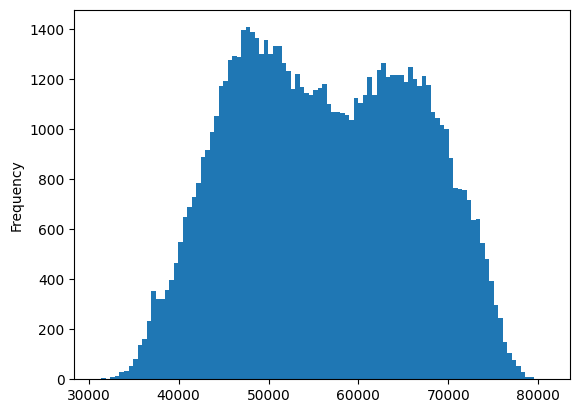

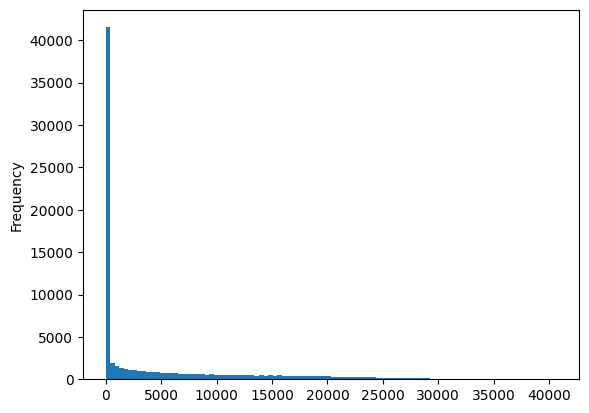

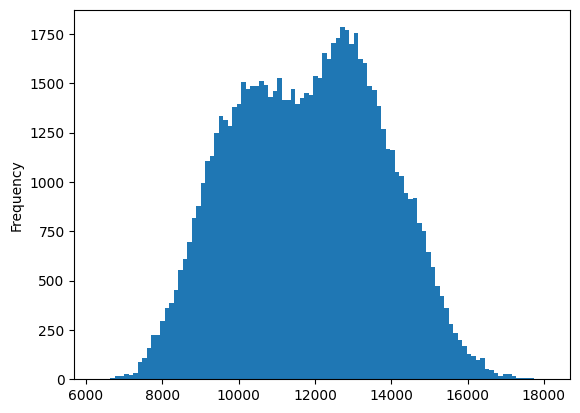

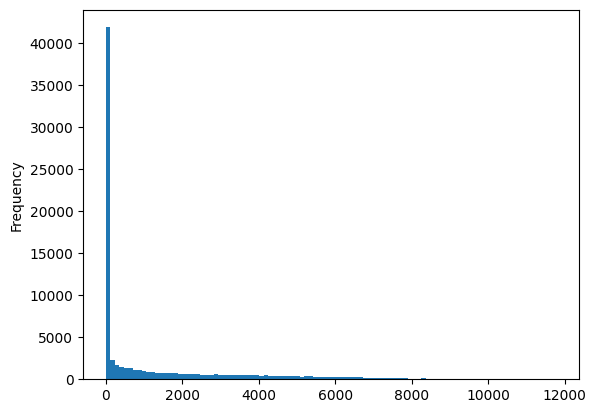

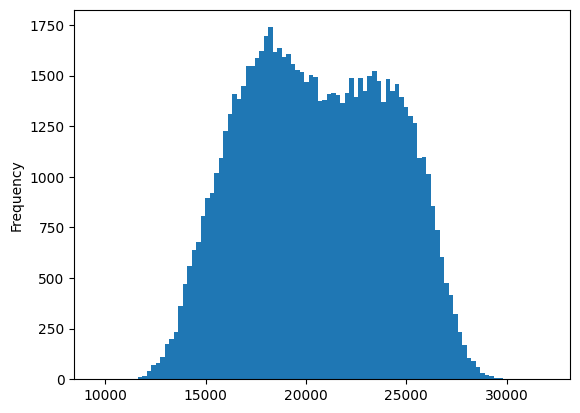

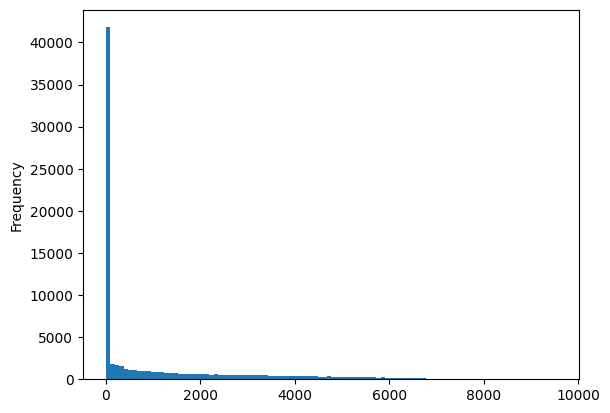

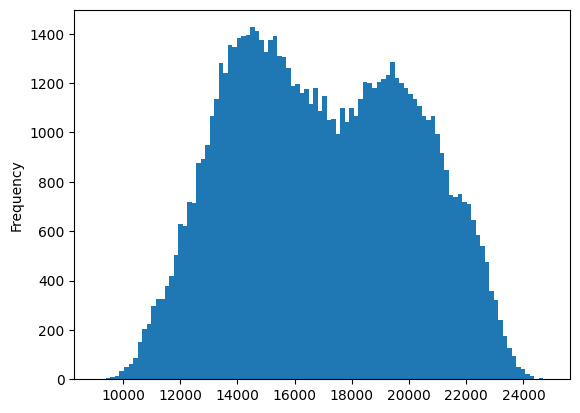

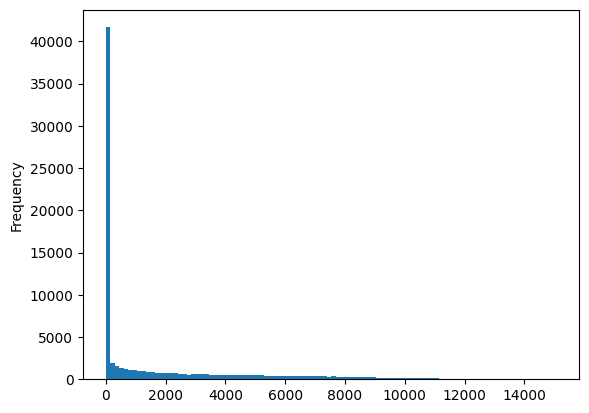

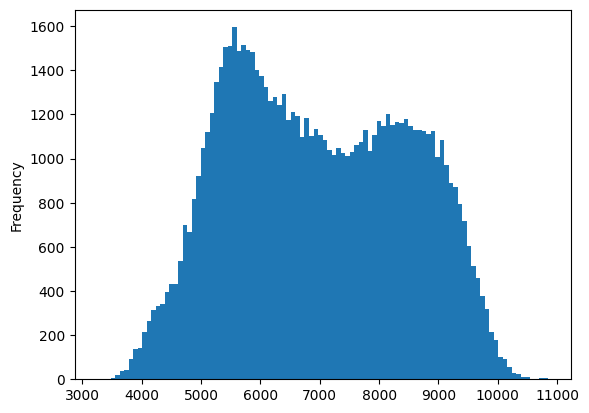

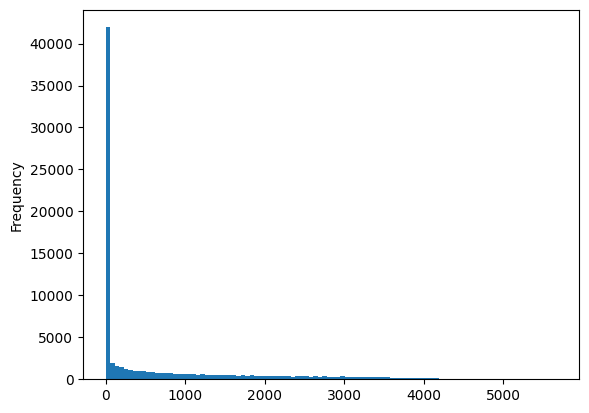

------------------ AT ------------------


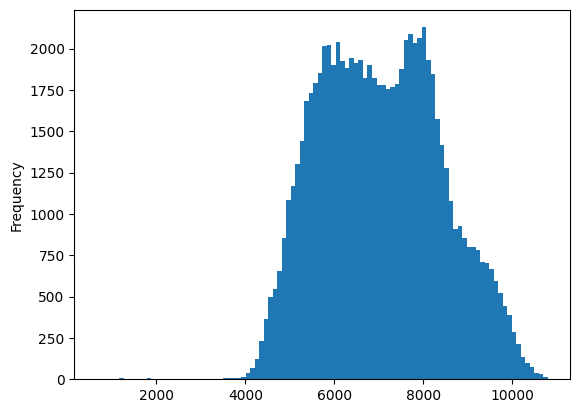

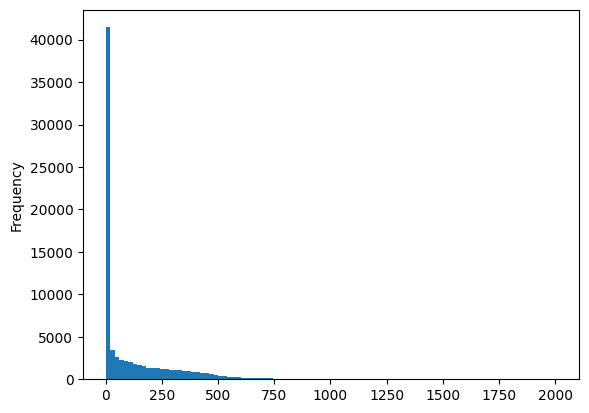

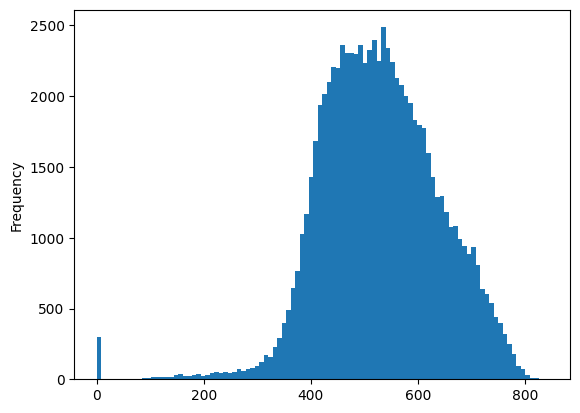

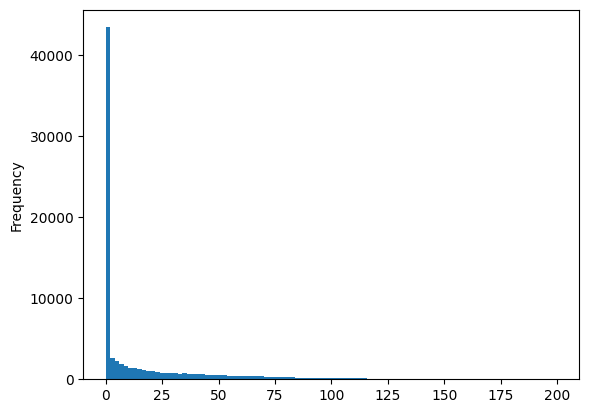

In [17]:
import matplotlib.pyplot as plt

df['load_DE'].plot.hist(bins=100)
plt.show()
df['solar_gen_DE'].plot.hist(bins=100)
plt.show()

df['load_DE_50Hertz'].plot.hist(bins=100)
plt.show()
df['solar_gen_DE_50Hertz'].plot.hist(bins=100)
plt.show()

df['load_DE_Amprion'].plot.hist(bins=100)
plt.show()
df['solar_gen_DE_Amprion'].plot.hist(bins=100)
plt.show()

df['load_DE_TenneT'].plot.hist(bins=100)
plt.show()
df['solar_gen_DE_TenneT'].plot.hist(bins=100)
plt.show()

df['load_DE_TransnetBW'].plot.hist(bins=100)
plt.show()
df['solar_gen_DE_TransnetBW'].plot.hist(bins=100)
plt.show()

print("------------------ AT ------------------")

df['load_AT'].plot.hist(bins=100)
plt.show()
df['solar_gen_AT'].plot.hist(bins=100)
plt.show()

df['load_LU'].plot.hist(bins=100)
plt.show()
df['solar_gen_LU'].plot.hist(bins=100)
plt.show()

In [18]:
df_cropped = df[49000:50000]
df_cropped.head(30)

,date,load_AT,load_DE,load_DE_50Hertz,load_DE_Amprion,load_DE_TenneT,load_DE_TransnetBW,load_LU,solar_gen_AT,wind_gen_AT,...,solar_gen_DE_50Hertz,wind_gen_DE_50Hertz,solar_gen_DE_Amprion,wind_gen_DE_Amprion,solar_gen_DE_TenneT,wind_gen_DE_TenneT,solar_gen_DE_TransnetBW,wind_gen_DE_TransnetBW,solar_gen_LU,wind_gen_LU
49000,2020-08-03 16:00:00+00:00,7425.25,57065.25,11537.50,20535.75,17513.50,7478.50,561.75,51.0,150.0,...,3152.00,1235.50,1649.75,1294.25,2532.00,1512.00,389.75,132.75,47.50,3.25
49001,2020-08-03 17:00:00+00:00,7292.50,56857.75,11596.75,20554.00,17450.25,7256.25,565.50,26.0,151.0,...,1949.50,1155.25,1005.00,1517.75,1615.75,1592.50,223.25,157.50,31.00,2.25
49002,2020-08-03 18:00:00+00:00,7038.00,56067.50,11506.50,20428.75,16978.75,7154.25,557.00,9.0,261.0,...,863.25,960.50,526.75,1383.50,717.50,1666.75,80.25,186.50,15.00,1.25
49003,2020-08-03 19:00:00+00:00,6705.75,54212.00,10986.50,20144.75,16197.00,6884.00,522.00,2.0,286.0,...,140.25,869.25,129.75,1011.00,145.00,1617.50,6.25,181.00,3.50,2.25
49004,2020-08-03 20:00:00+00:00,6259.25,52430.50,10617.50,19619.25,15570.75,6622.25,512.00,0.0,445.0,...,0.00,1241.25,1.75,731.00,1.25,1783.25,0.00,128.25,0.00,36.00
49005,2020-08-03 21:00:00+00:00,5915.00,49200.50,9980.50,18416.25,14731.00,6073.25,493.50,0.0,466.0,...,0.00,1396.75,0.00,625.75,0.00,2167.25,0.00,96.50,0.00,36.75
49006,2020-08-03 22:00:00+00:00,5428.00,44933.25,9244.25,16466.00,13595.25,5628.50,461.00,0.0,402.0,...,0.00,1452.00,0.00,605.25,0.00,2157.50,0.00,89.50,0.00,47.00
49007,2020-08-03 23:00:00+00:00,5148.50,42203.75,8683.50,15432.50,12820.25,5267.75,438.25,0.0,306.0,...,0.00,1654.75,0.00,683.25,0.00,1804.25,0.00,97.75,0.00,53.75
49008,2020-08-04 00:00:00+00:00,4865.00,40838.00,8387.00,14845.50,12612.75,4992.75,419.50,0.0,477.0,...,0.00,1945.25,0.00,779.50,0.00,1839.25,0.00,125.75,0.00,66.25
49009,2020-08-04 01:00:00+00:00,4760.00,39984.00,8260.25,14476.75,12365.00,4882.25,414.00,0.0,712.0,...,0.00,2110.50,0.00,846.00,0.00,1856.00,0.00,140.50,0.00,73.25


['load_AT', 'load_DE', 'load_DE_50Hertz', 'load_DE_Amprion', 'load_DE_TenneT', 'load_DE_TransnetBW', 'load_LU', 'solar_gen_AT', 'wind_gen_AT', 'solar_gen_DE', 'wind_gen_DE', 'solar_gen_DE_50Hertz', 'wind_gen_DE_50Hertz', 'solar_gen_DE_Amprion', 'wind_gen_DE_Amprion', 'solar_gen_DE_TenneT', 'wind_gen_DE_TenneT', 'solar_gen_DE_TransnetBW', 'wind_gen_DE_TransnetBW', 'solar_gen_LU', 'wind_gen_LU']
21


IndexError: index 14 is out of bounds for axis 0 with size 14

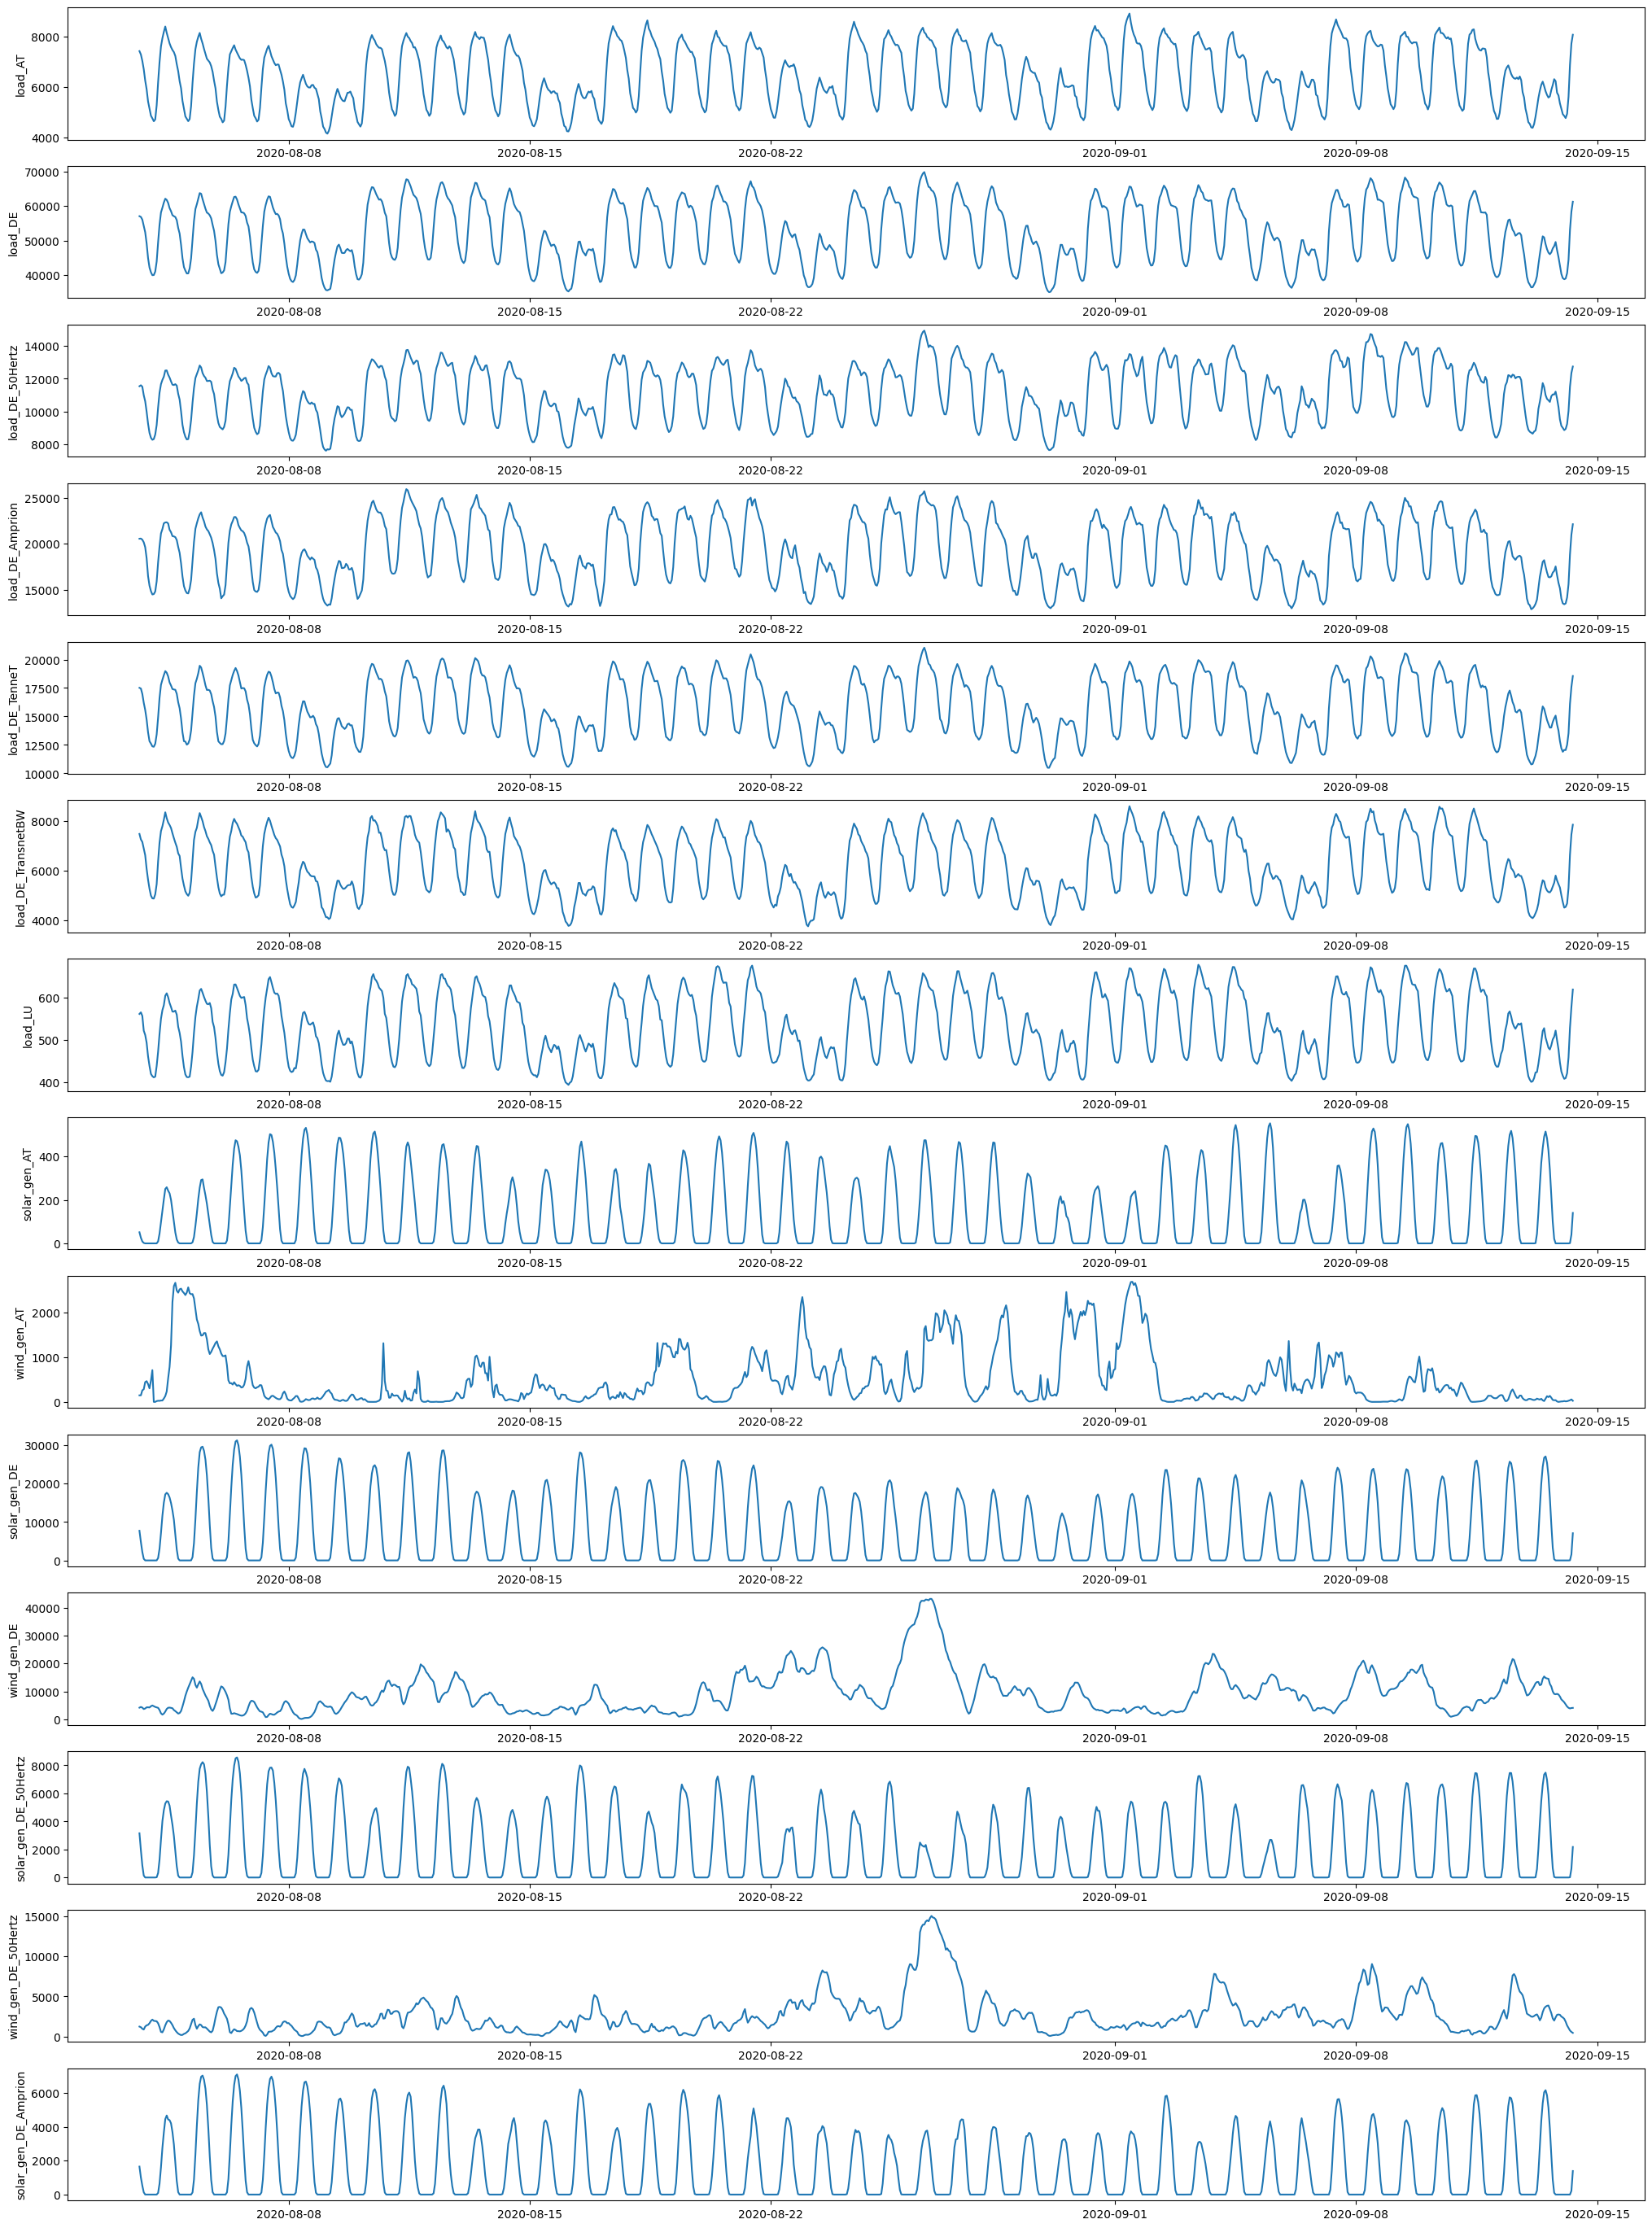

In [19]:
# plot different time series
skip_days = 14
skip_hours = 24*skip_days

keys = list(df.drop(columns="date").columns)
print(keys)
print(len(keys))
labels = keys
axis_labels = ["Load [MWh]", "Wind generation [MWh]", "Solar generation [MWh]"]

fig, axs = plt.subplots(14,1, figsize=(25,35), dpi=100)

for i, (key, label) in enumerate(zip(keys, labels)):
    axs[i].plot(df_cropped['date'], df_cropped[key], label=label)
    #axs[i].set_xticks(np.array(list(df_cropped['date']))[::skip_hours])
    #axs[i].legend()
    font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 10}

    matplotlib.rc('font', **font)
    #axs[i].set_xlabel("Time")
    axs[i].set_ylabel(keys[i])
#font = {'family' : 'arial',
        #'weight' : 'bold',
        #'size'   : 22}

matplotlib.rc('font', **font)
plt.show()

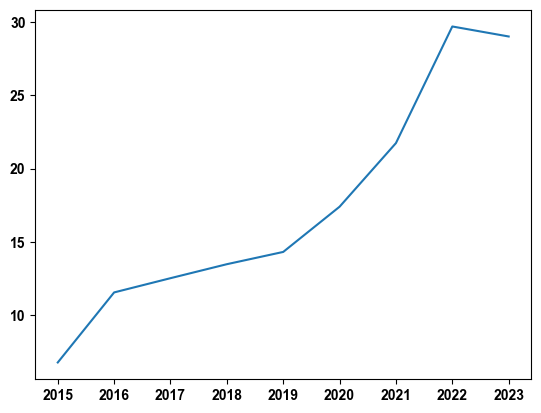

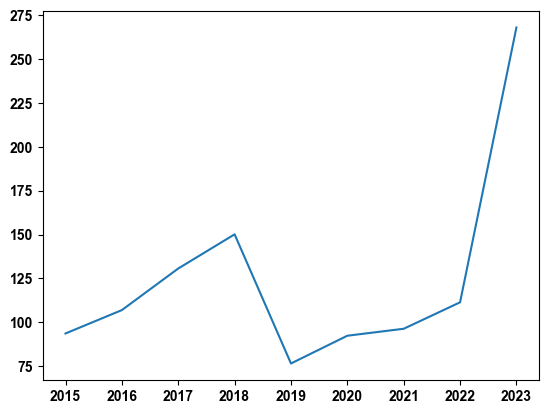

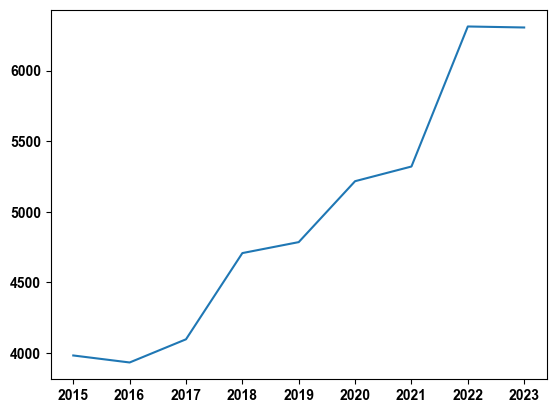

In [ ]:
# plot 
means = df["solar_gen_LU"].groupby(df["date"].dt.year).mean()
plt.plot(means)
plt.show()
means = df["solar_gen_AT"].groupby(df["date"].dt.year).mean()
plt.plot(means)
plt.show()
means = df["solar_gen_DE"].groupby(df["date"].dt.year).mean()
plt.plot(means)

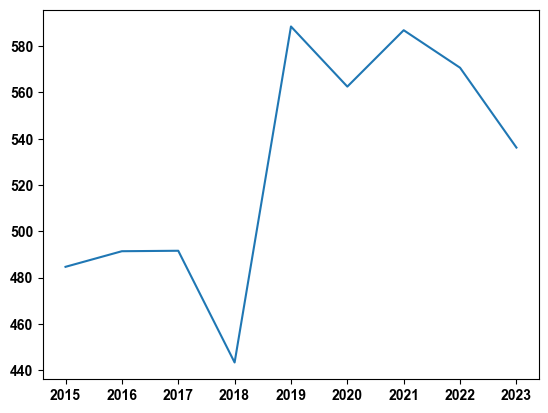

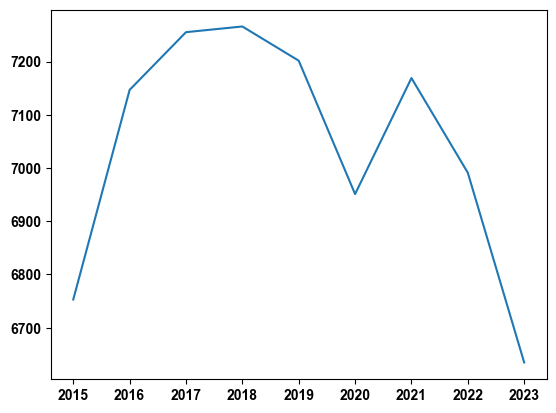

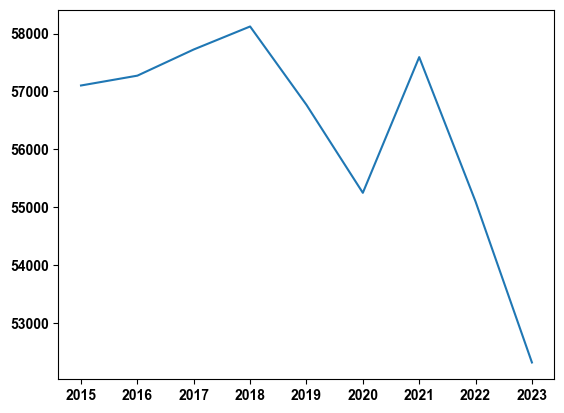

In [ ]:
# plot 
means = df["load_LU"].groupby(df["date"].dt.year).mean()
plt.plot(means)
plt.show()
means = df["load_AT"].groupby(df["date"].dt.year).mean()
plt.plot(means)
plt.show()
means = df["load_DE"].groupby(df["date"].dt.year).mean()
plt.plot(means)

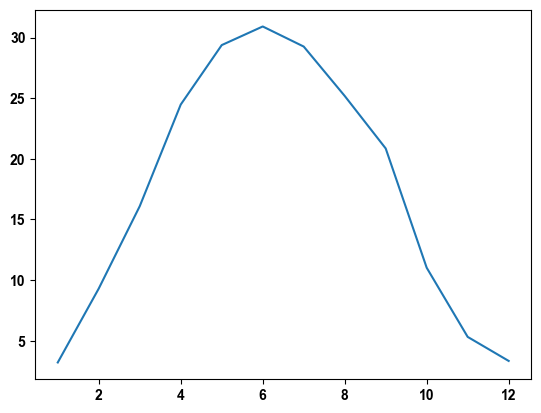

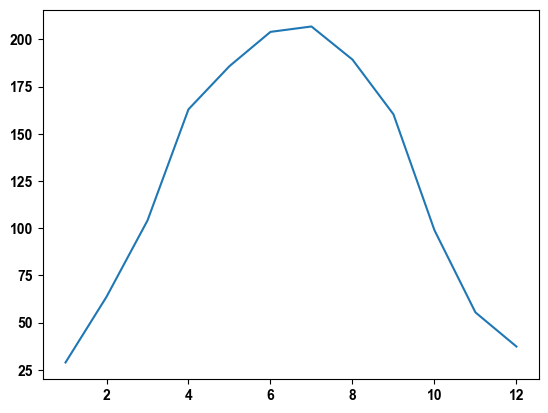

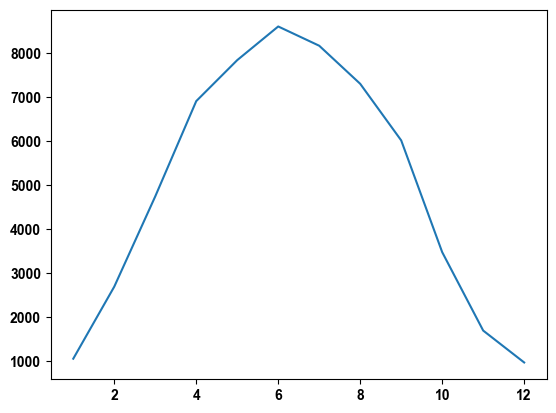

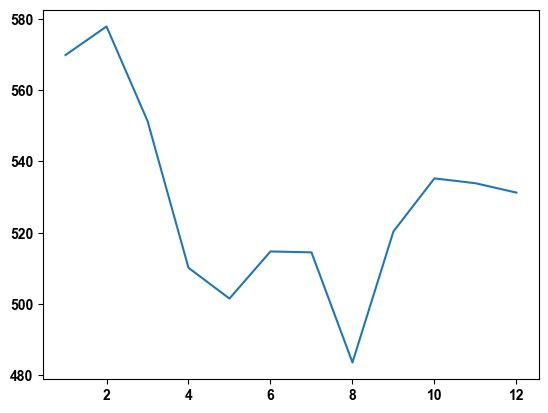

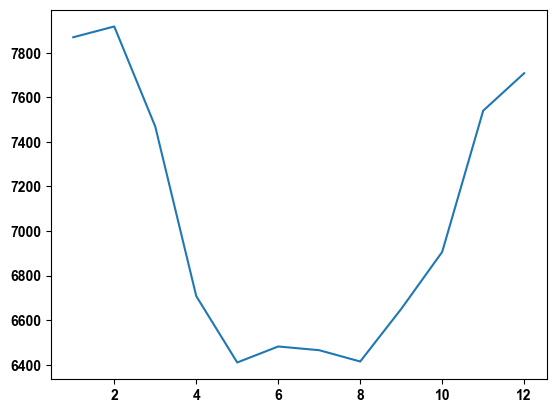

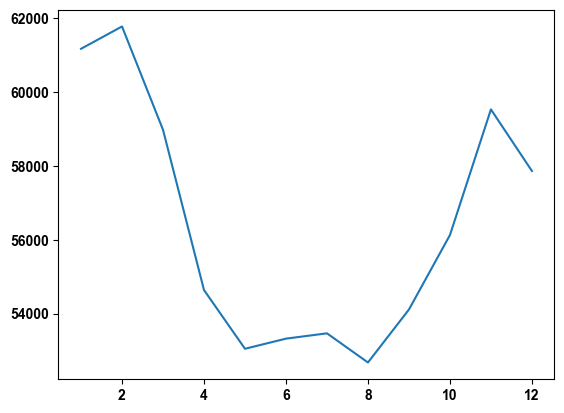

In [ ]:
# plot
# plot 

means = df["solar_gen_LU"].groupby(df["date"].dt.month).mean()
plt.plot(means)
plt.show()
means = df["solar_gen_AT"].groupby(df["date"].dt.month).mean()
plt.plot(means)
plt.show()
means = df["solar_gen_DE"].groupby(df["date"].dt.month).mean()
plt.plot(means)
plt.show()

means = df["load_LU"].groupby(df["date"].dt.month).mean()
plt.plot(means)
plt.show()
means = df["load_AT"].groupby(df["date"].dt.month).mean()
plt.plot(means)
plt.show()
means = df["load_DE"].groupby(df["date"].dt.month).mean()
plt.plot(means)
plt.show()

# Dunkelflaute in autumn (less sun but not yet a lot of wind)

In [ ]:
#means = df["hydro_storage_gen"].groupby(df["date"].dt.month).mean()
#plt.plot(means)

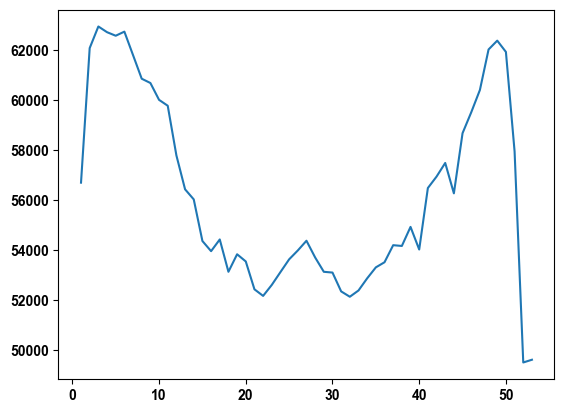

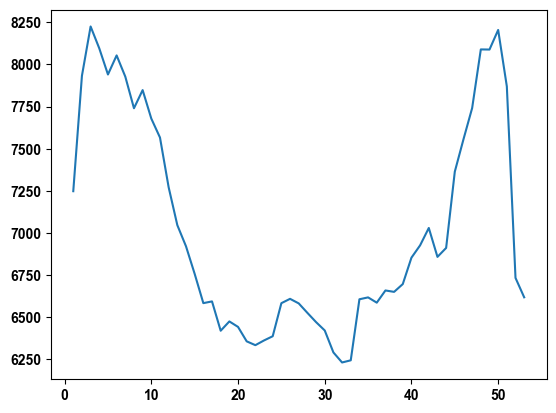

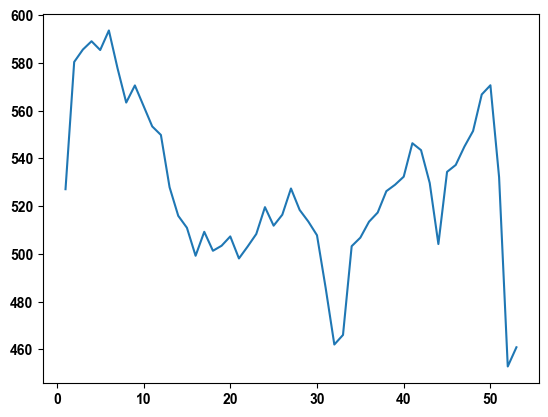

In [ ]:
means_load = df["load_DE"].groupby(df["date"].dt.isocalendar().week).mean()
plt.plot(means_load, label="load")
plt.show()

means_load = df["load_AT"].groupby(df["date"].dt.isocalendar().week).mean()
plt.plot(means_load, label="load")
plt.show()

means_load = df["load_LU"].groupby(df["date"].dt.isocalendar().week).mean()
plt.plot(means_load, label="load")
plt.show()

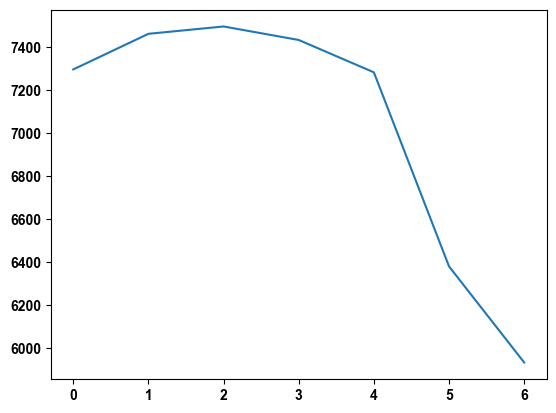

In [ ]:
means_load = df["load_AT"].groupby(df["date"].dt.dayofweek).mean()
plt.plot(means_load, label="load")

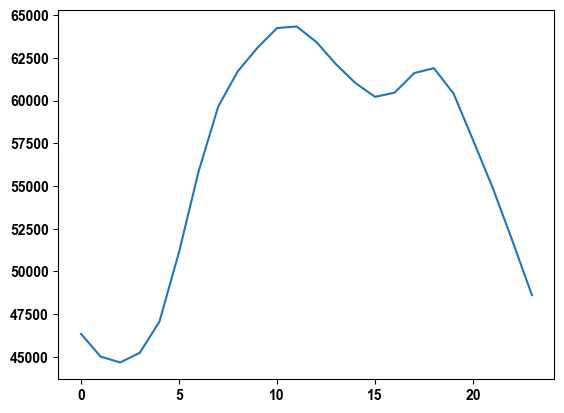

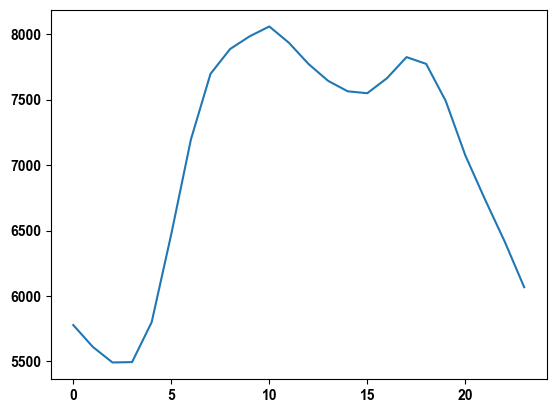

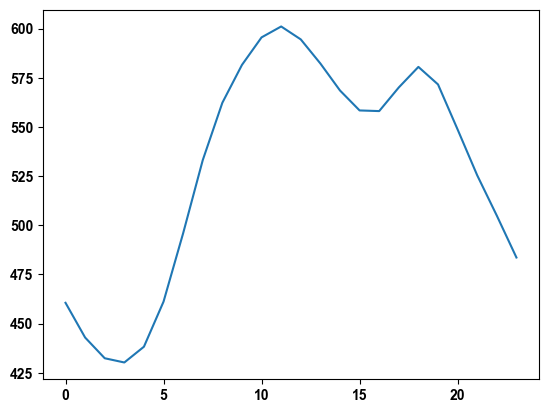

In [ ]:
means_load = df["load_DE"].groupby(df["date"].dt.hour).mean()
plt.plot(means_load, label="load")
plt.show()
means_load = df["load_AT"].groupby(df["date"].dt.hour).mean()
plt.plot(means_load, label="load")
plt.show()
means_load = df["load_LU"].groupby(df["date"].dt.hour).mean()
plt.plot(means_load, label="load")